## 02: Model checking


### Model Check I: Posterior predictive check
Just because the model converged does not give any guarentee that the model is an appropriate fit for the underlying data. One method of checking model fit is called the posterior predictive check. This is formally represented as:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

TODO: Add comments on this

PYMC provides a convienant way to sample from the fitted model. You may have noticed a new line in the above model specification: 

`y_pred = pm.Poisson('y_pred', mu=mu)`

This is almost identical to `y_est` except we do not specify the observed data. Pymc considered this to be a stochastic node (as opposed to an observed node). As the MCMC model samples from the posterior distribution of $\mu$, it is computing values for `y_pred`.

We then plot `y_pred` below and compare it to teh observed data `y_est`

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

In [3]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu) # ignore: we will talk about this later
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.6 sec

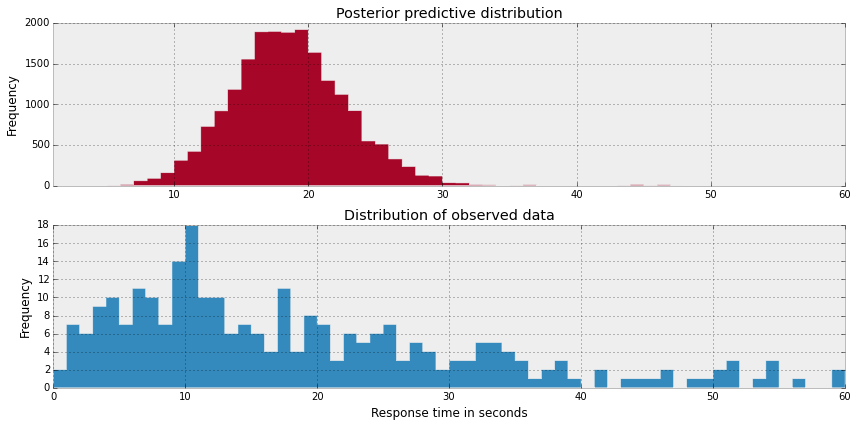

In [4]:
x_lim = 60
y_pred = trace.get_values('y_pred')
mu_mean = trace.get_values('mu').mean()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Choosing the right distribution
I'm not particularly happy with the above plot. Ideally, I'd like the posterior predictive distribution to somewhat resemble the distribution of observed data. Clearly we are not seeing that.

One other option we have is the Negative Binomial distribution. This has very similar characteristics to the Poisson distribution except that is has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of its mean. recall that the Poisson has one parameters ($\mu$) that represents both its mean and its variance.

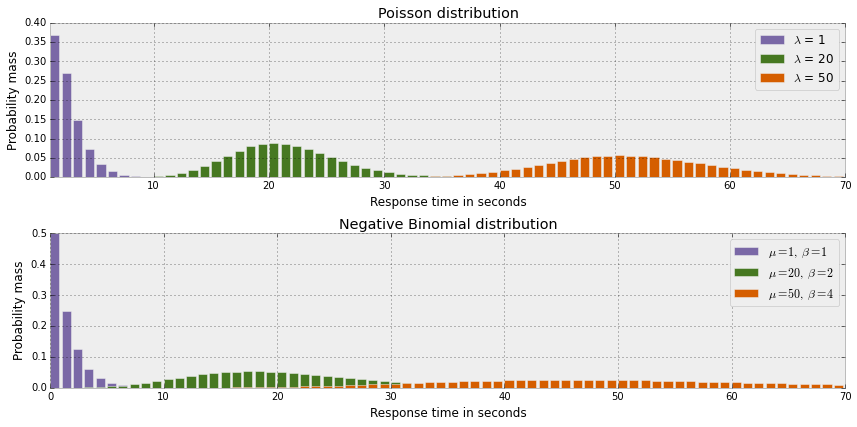

In [5]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)
x_lim = 70
mu = [1, 20, 50]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[2])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[4])
    
_ = plt.xlim(1, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Poisson distribution')
_ = plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1],
                '$\lambda$ = %s' % mu[2]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [1, 2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[2])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[2], a[2]), p=get_p(mu[2], a[2])), color=colors[4])

_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Negative Binomial distribution')
_ = plt.legend(['$\\mu = %s, \/ \\beta = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[1], a[1]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[2], a[2])])

plt.tight_layout()

Lets go ahead and estimate the parameters for a Negative Binomial data given the same dataset used before. Again, we will use a Uniform distribution to estimate both $\mu$ and $\alpha$. The model can be represented as:

$$y_{j} \sim NegBinomial(\mu, \alpha)$$
$$\mu = Uniform(0, 100)$$
$$\alpha = Uniform(0,100)$$

In [6]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=0, upper=100)
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

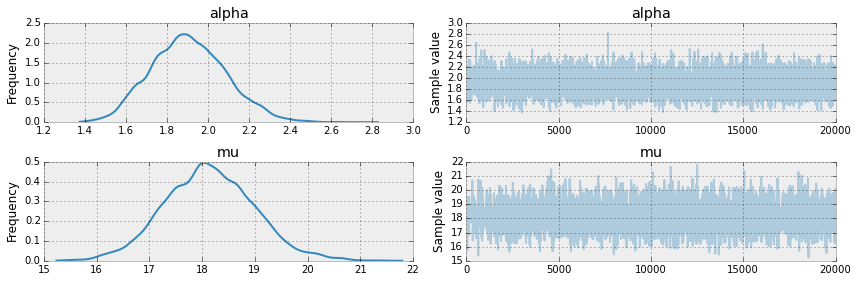

In [7]:
_ = pm.traceplot(trace, vars=['alpha', 'mu'])

We see the above model has greater uncertinity around the estimation of the mean response time $(\mu)$ for chat messages:
- Poisson: 17.5 to 18.5
- Negative Binomial: 16 to 21

Additionally, the Negative Binonomial model has an $\alpha$ parameter of 1.4 to 2.4 which further increases the variance in the estimated parameter `y_est`.

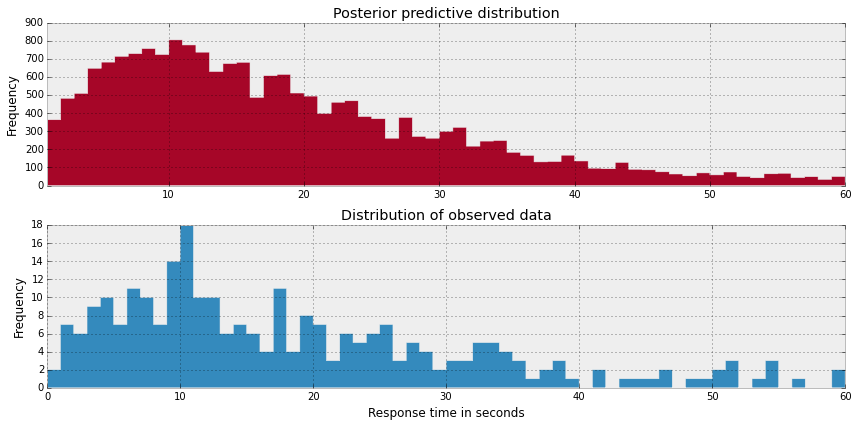

In [8]:
x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

The posterior predictive check involves a visual inspection between the observed data and the sampled data from the posterior predictive distribution. We can conclude that the Negative Binomial model is a better fit than the Poisson model.

If you find yourself doubting the rigor of this model checking approach, there are other more analytical methods. 

### Model Check II: Bayes Factor
One technique is to compute the Bayes Factor. Add some theory on Bayes Factor here

 [-----------------100%-----------------] 20000 of 20000 complete in 12.9 sec

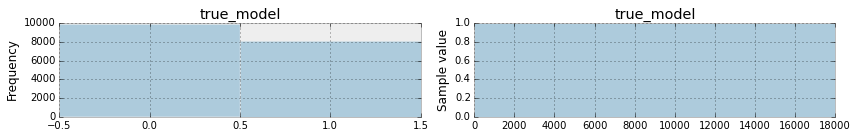

In [10]:
# Compute bayes facor comparing poisson to negbinomial
# Sample code from https://github.com/pymc-devs/pymc3/issues/812

with pm.Model() as model:
    
    # Index to true model
    true_model = pm.DiscreteUniform('true_model', lower=0, upper=1)
    
    # Poisson parameters
    mu_p = pm.Uniform('mu_p', 0, 100)

    # Negative Binomial parameters
    alpha = pm.Uniform('alpha', lower=0, upper=100)
    mu_nb = pm.Uniform('mu_nb', lower=0, upper=100)

    y_like = pm.DensityDist('y_like',
             lambda value: pm.switch(true_model, 
                 pm.Poisson.dist(mu_p).logp(value),
                 pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)
             ),
             observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategoricalStep(var=true_model, values=[0,1])
    trace = pm.sample(20000, step=[step1, step2], start=start)

_ = pm.traceplot(trace[2000:], vars=['true_model'])

We can calculate the Bayes Factor for the above two models using the below formulation:

$$Posterior Odds = Bayes Factor * Prior Odds$$

$$\frac{P(M_{1}|D)}{P(M_{2}|D)} = B.F. \times \frac{P(M_{1})}{P(M_{2})}$$

Given that we applied equal prior odds to each model, the Bayes Factor is simple the quotient of the model likelihoods.

In [11]:
# Compute the bayes factor
prob_pois = trace[5000:]['true_model'].mean()
prob_nb = 1 - prob_pois
BF = (prob_nb/prob_pois)
print "Bayes Factor: %s" % BF

Bayes Factor: 1.2502250225


A Bayes Factor of >1 suggests that $M_1$ (Negative Binomial) is more strongly supported by the data than $M_2$ (Poisson). Jeffreys' scale of evidence for Bayes factors interprets a BF of 1.39 as there being weak evidence of $M_1$ over $M_2$ given the data. Combining the posterior predictive check and bayes factor I will conclude that the Negative Binomial is a better model for the given data.

In [12]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()